## Imports and reading dataset


!pip install transformers torch

!pip install seqeval

!pip install git+https://www.github.com/keras-team/keras-contrib.git

!pip install googletrans==4.0.0-rc1
!pip install --upgrade googletrans==4.0.0-rc1

In [2]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter

from gensim.models import FastText

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from sklearn.metrics import accuracy_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModel
from transformers import RobertaModel, RobertaTokenizer
from concurrent.futures import ProcessPoolExecutor


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Embedding, Flatten
from keras.utils import to_categorical
from keras.layers import Dropout

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("C:/Users/husse/Desktop/emotion_classification/dataset/new_merged_df.csv")
df

,text,emotion
0,da ana lma atkharrag,joy
1,baad el fetar hagelko,neutral
2,hahahahahha helw elkalam dah,happiness
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral
4,dah elly ana asdi aleih harfyan,neutral
...,...,...
2804,eh el araf da ana mt3sab,angry
2805,tab law omt w gbthalk..,neutral
2806,ana msh msda2 ana masdoom,surprise
2807,eh el mofg2at el 8areba de,surprise


neutral: Count = 867 -----------------> Percentage = 30.87%
joy: Count = 694 -----------------> Percentage = 24.71%
happiness: Count = 547 -----------------> Percentage = 19.47%
angry: Count = 394 -----------------> Percentage = 14.03%
sadness: Count = 155 -----------------> Percentage = 5.52%
surprise: Count = 91 -----------------> Percentage = 3.24%
fear: Count = 61 -----------------> Percentage = 2.17%
df shape : (2809, 2)


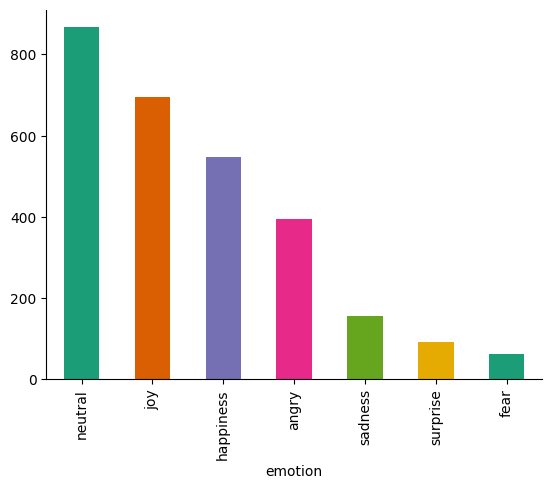

In [4]:
df.groupby('emotion').size().sort_values(ascending=False).plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Calculating and printing percentages in descending order
emotion_counts = df['emotion'].value_counts()
total_samples = len(df)

for emotion, count in emotion_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{emotion}: Count = {count} -----------------> Percentage = {percentage:.2f}%")
print("df shape :",f"{df.shape}")

## a) Step 1 : Preprocessing

<!-- + Remove URLs
+ Remove user mentions
+ Remove hashtags
+ Remove punctuation
+ Tokenize the text
+ Convert to lower case
+ Join the tokens back into a clean text -->

<!-- + Remove repeated letters -->




In [5]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs https://www.example.com/
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove user mentions @mohamed_samy
    text = re.sub(r'#', '', text)  # Remove hashtags #free_palestine
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation period, comma, apostrophe, quotation, question, exclamation, brackets, braces, parenthesis, dash, hyphen, ellipsis, colon, semicolon
    
    tokens = nltk.word_tokenize(text)  # Tokenize the text

    # Remove repeated letters (commented out as per your preference)
    # tokens = [re.sub(r'(.)\1+', r'\1', word) for word in tokens]

    tokens = [word.lower() for word in tokens]  # Convert to lowercase
    clean_text = ' '.join(tokens)  # Join the tokens back into a clean text

    return clean_text

df['clean_text'] = df['text'].apply(clean_text)  # Apply the clean_text function to the 'text' column in the DataFrame
df


,text,emotion,clean_text
0,da ana lma atkharrag,joy,da ana lma atkharrag
1,baad el fetar hagelko,neutral,baad el fetar hagelko
2,hahahahahha helw elkalam dah,happiness,hahahahahha helw elkalam dah
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral,kan 3ayz yroh yl3ab fe pyramids bayen
4,dah elly ana asdi aleih harfyan,neutral,dah elly ana asdi aleih harfyan
...,...,...,...
2804,eh el araf da ana mt3sab,angry,eh el araf da ana mt3sab
2805,tab law omt w gbthalk..,neutral,tab law omt w gbthalk
2806,ana msh msda2 ana masdoom,surprise,ana msh msda2 ana masdoom
2807,eh el mofg2at el 8areba de,surprise,eh el mofg2at el 8areba de


## Word embedding  

In [6]:
# Load AraBERT tokenizer and model
model_name = "aubmindlab/bert-base-arabertv02"
AraBERT_tokenizer = AutoTokenizer.from_pretrained(model_name)
AraBERT_model = AutoModel.from_pretrained(model_name)

In [7]:
def get_arabert_embedding(text):
    tokens = AraBERT_tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        model_output = AraBERT_model(**tokens)
        
    # Return the embeddings for the [CLS] token
    return model_output.last_hidden_state[:, 0, :].numpy()

In [8]:
# Apply the get_arabert_embedding function to the 'cleanedText' column
df['arabert_embedding'] = df['clean_text'].apply(get_arabert_embedding)

In [9]:
df

,text,emotion,clean_text,arabert_embedding
0,da ana lma atkharrag,joy,da ana lma atkharrag,"[[0.5454751, 0.43432683, -0.07378585, -1.57207..."
1,baad el fetar hagelko,neutral,baad el fetar hagelko,"[[1.1536006, 0.8544052, -0.20398256, -2.017871..."
2,hahahahahha helw elkalam dah,happiness,hahahahahha helw elkalam dah,"[[0.94547844, 0.38081047, -0.40354136, -1.1815..."
3,kan 3ayz yroh yl3ab fe pyramids bayen,neutral,kan 3ayz yroh yl3ab fe pyramids bayen,"[[0.39184567, 0.15342335, -0.05676457, -1.4388..."
4,dah elly ana asdi aleih harfyan,neutral,dah elly ana asdi aleih harfyan,"[[0.5287757, 0.11002311, -0.23975497, -1.26346..."
...,...,...,...,...
2804,eh el araf da ana mt3sab,angry,eh el araf da ana mt3sab,"[[1.0628017, -0.35265028, -0.4830385, -1.78744..."
2805,tab law omt w gbthalk..,neutral,tab law omt w gbthalk,"[[1.3995427, 0.48281622, -0.05384671, -0.84097..."
2806,ana msh msda2 ana masdoom,surprise,ana msh msda2 ana masdoom,"[[0.6048813, 1.2163547, -0.28346315, -2.001335..."
2807,eh el mofg2at el 8areba de,surprise,eh el mofg2at el 8areba de,"[[0.75176287, -0.99444634, 0.09746289, -1.0685..."


## c) Step 3: Models Development
<!-- + Split data into 80% train and 20% test
+ Bi-LSTM model devalopment
+ CNN model devalopment -->

<!-- https://en.wikipedia.org/wiki/Conditional_random_field#:~:text=Conditional%20random%20fields%20(CRFs)%20are,can%20take%20context%20into%20account. -->

In [17]:
X = df['arabert_embedding'].to_numpy()
y = df['emotion']

# Use LabelEncoder to encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Pad sequences to have the same length
X_train_pad = pad_sequences(X_train, padding='post', dtype='float32')
X_test_pad = pad_sequences(X_test, padding='post', dtype='float32')

In [18]:
# Bidirectional LSTM model
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_pad.shape[1], X_train_pad.shape[2])))
lstm_model.add(Bidirectional(LSTM(32)))
lstm_model.add(Dense(len(df['emotion'].unique()), activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_prob = lstm_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get class names
class_names = label_encoder.classes_

# Print class names in the classification report
report = classification_report(y_test, y_pred, target_names=class_names)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2%}")

Epoch 1/5
57/57 [==============================] - 7s 31ms/step - loss: 1.6822 - accuracy: 0.3072 - val_loss: 1.6476 - val_accuracy: 0.3067
Epoch 2/5
57/57 [==============================] - 0s 7ms/step - loss: 1.6374 - accuracy: 0.3228 - val_loss: 1.6155 - val_accuracy: 0.3400
Epoch 3/5
57/57 [==============================] - 0s 7ms/step - loss: 1.6027 - accuracy: 0.3461 - val_loss: 1.6780 - val_accuracy: 0.3156
Epoch 4/5
57/57 [==============================] - 0s 7ms/step - loss: 1.5922 - accuracy: 0.3511 - val_loss: 1.5897 - val_accuracy: 0.3489
Epoch 5/5
18/18 [==============================] - 1s 2ms/step
Accuracy: 35.05%


In [19]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.39      0.24      0.30        74
        fear       0.00      0.00      0.00        11
   happiness       0.40      0.13      0.19       109
         joy       0.30      0.84      0.45       143
     neutral       0.52      0.26      0.34       175
     sadness       0.00      0.00      0.00        35
    surprise       0.00      0.00      0.00        15

    accuracy                           0.35       562
   macro avg       0.23      0.21      0.18       562
weighted avg       0.37      0.35      0.30       562

